<a href="https://colab.research.google.com/github/yaramohamadi/dermo-segmentation/blob/master/segment_128_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import random
import time

from sklearn.feature_extraction.image import extract_patches_2d
from skimage.util import view_as_blocks
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from math import floor, ceil
from skimage.filters import rank
from skimage.morphology import disk, dilation
from skimage.feature import canny
from skimage.util import view_as_blocks, view_as_windows
from sklearn.metrics import roc_curve, auc
import re
from math import ceil
from scipy.ndimage import gaussian_filter, map_coordinates, rotate

In [3]:
im_dir = '/content/drive/My Drive/warwick/dataset'
writer = tf.python_io.TFRecordWriter('/content/drive/My Drive/warwick/train.tfrecords')
#files = os.listdir(s_dir)

#patch_size = (64 + 32, 320 + 32)
#step_size = (256 - 32, 320 - 32)
#middle_point = (256, 320)
patch_size = (128, 128)

stat = {
    '0': 0,
    '1:20': 0,
    '20:40': 0,
    '40:60': 0,
    '60:80': 0,
    '80:100': 0
}

train_files = 85 + 1
test_files = 60 + 1
dataset_size = 0

random.seed(time.time())


def int64_feature(_value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[_value]))


def bytes_feature(_value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_value]))

input('wanna overwrite?')


def elastic_transform(image, alpha=1000, sigma=30, spline_order=1, mode='nearest', random_state=np.random):
    assert image.ndim == 3
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    for i in range(image.shape[2]):
        result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    return result 




for i in range(1, train_files): 

    print(i)

    im_file = 'train_' + str(i) + '.bmp'
    gt_file = 'train_' + str(i) + '_anno.bmp'

    #read and normalize
    s = imageio.imread(os.path.join(im_dir, im_file))
    #s[:,:,0] = rank.equalize(s[:,:,0], selem = disk(patch_size[0]))
    mean = np.mean(s)
    std = np.std(s)
    s = (s - mean) / std
    gt = imageio.imread(os.path.join(im_dir, gt_file)).astype(np.bool).astype(np.uint8)


    # width and height offset to cut out to be able to divide image into correct patch sizes
    h_o = (len(s) % patch_size[0]) / 2
    w_o = (len(s[0]) % patch_size[1]) / 2
    x_s, y_s = floor(w_o), floor(h_o)
    h_new, w_new = int(len(s)/patch_size[0])*patch_size[0], int(len(s[0])/patch_size[1])*patch_size[1]
    s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
    gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]
    
    #___
    image = np.dstack((s, gt))
    #image_patches = view_as_blocks(image, (patch_size[0], patch_size[1], 4)).reshape(-1, patch_size[0], patch_size[1], 4)

    #___
    image_patches = extract_patches_2d(image, patch_size, 400)
    #___
    #image_patches = []
    #image_patches.append(image[:patch_size[0], :patch_size[1], :])
    #image_patches.append(image[:patch_size[0], step_size[1]:, :])
    #image_patches.append(image[step_size[0]:, :patch_size[1], :])
    #image_patches.append(image[step_size[0]:, step_size[1]:, :])
    #___

    for instance in image_patches:
        img_patch = instance[:, :, :-1]
        gt_patch = instance[:, :, -1]

        ratio = np.count_nonzero(gt_patch) / (patch_size[0] * patch_size[1])

        flag = 0

        if ratio == 0:
            if random.random() < 0.919652551574:
                stat['0'] += 1
                flag = 1
        elif ratio < 0.2:
            if random.random() < 1:
                stat['1:20'] += 1
                flag = 1
        elif ratio < 0.4:
            if random.random() <  0.744288224956:
                stat['20:40'] += 1
                flag = 1
        elif ratio < 0.6:
            if random.random() < 0.476110174255:
                stat['40:60'] += 1
                flag = 1
        elif ratio < 0.8:
            if random.random() < 0.441145833333:
                stat['60:80'] += 1
                flag = 1
        else:
            if random.random() < 0.446965699208:
                stat['80:100'] += 1
                flag = 1
        if flag:
            dataset_size += 1
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        'image': bytes_feature(img_patch.astype(np.float32).tostring()),
                        'label': bytes_feature(gt_patch.astype(np.int32).tostring())
                    }
                ))
            writer.write(example.SerializeToString())
      
            if random.random() < 0.34:    
              dataset_size += 1               
              instance = elastic_transform(instance)

              example = tf.train.Example(
                  features=tf.train.Features(
                      feature={
                          'image': bytes_feature(img_patch.astype(np.float32).tostring()),
                          'label': bytes_feature(gt_patch.astype(np.int32).tostring())
                      }
                  ))
              writer.write(example.SerializeToString())

writer.close()
print("Created dataset successfully")
print(dataset_size)
for key, value in stat.items():
    print(key, ' ----> ', value)


wanna overwrite?
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Created dataset successfully
27187
0  ---->  3034
1:20  ---->  3806
20:40  ---->  3289
40:60  ---->  3366
60:80  ---->  3434
80:100  ---->  3371


In [0]:

train_file = '/content/drive/My Drive/warwick/train.tfrecords'

result_images_file = '/content/drive/My Drive/warwick/results/%d'
result_images_folder = '/content/drive/My Drive/warwick/results'
im_dir = '/content/drive/My Drive/warwick/dataset/'
stat_file = '/content/drive/My Drive/warwick/results.txt'

save_path = '/content/drive/My Drive/warwick/checkpoints/best_validation'
load_dir = '/content/drive/My Drive/warwick/checkpoints/'
save_path_test = '/content/drive/My Drive/warwick/checkpoints_test/best_validation'
load_dir_test = '/content/drive/My Drive/warwick/checkpoints_test/'

pad_amount = 0
middle_point = (128, 128)
patch_size = (128 + pad_amount, 128 + pad_amount)
step_size = (128 - pad_amount, 128 - pad_amount)

lr = 0.0001
skip_connection_out_size = (int(ceil(patch_size[0]/8)), int(ceil(patch_size[1]/8)))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
(?, 128, 128, 3)
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 8, 8, 512)
(?, 4, 4, 512)
(?, 4, 4, 2)
(?, 16, 16, 2)
(?, 16, 16, 2)
(?, 16, 16, 2)
(?, 128, 128, 2)
Trying to restore last checkpoint ...
I

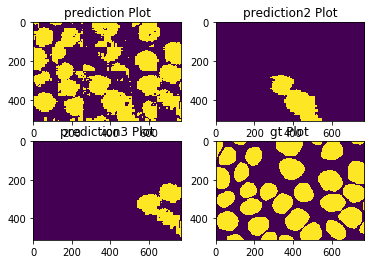

pred2: 0.5569856614716019
pred3: 0.5570784561241133
Epoch: 80, Current Dice: 0.8299, Best Dice: 0.8755

00:22:15
00:25:06
00:28:41
00:31:36
00:34:42


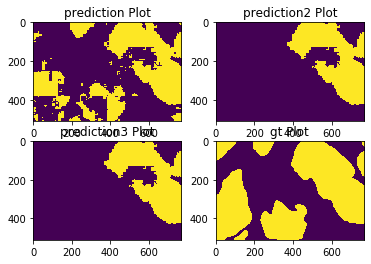

pred2: 0.5711522655844532
pred3: 0.5723068643447958
Epoch: 85, Current Dice: 0.8642, Best Dice: 0.8755

00:37:52
00:40:38
00:43:24
00:46:48
00:50:11


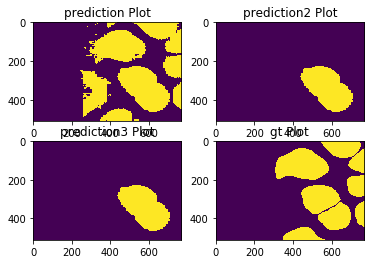

pred2: 0.5653827872670691
pred3: 0.5653827872670691
Epoch: 90, Current Dice: 0.8736, Best Dice: 0.8755

00:53:16
00:56:11
00:59:24
01:02:27
01:05:34


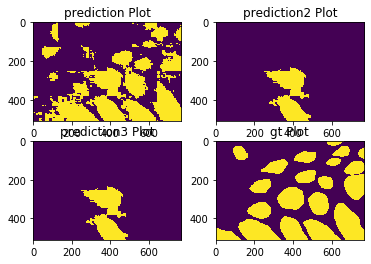

pred2: 0.5780341814447398
pred3: 0.5791627411217504
Epoch: 95, Current Dice: 0.8759, Best Dice: 0.8755

01:08:35
01:11:25
01:14:20
01:17:28
01:20:50


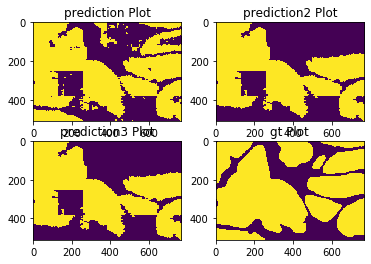

pred2: 0.5797044012636329
pred3: 0.5797044012636329
Epoch: 100, Current Dice: 0.8805, Best Dice: 0.8759

01:23:58
01:26:54
01:29:50
01:32:47
01:35:43


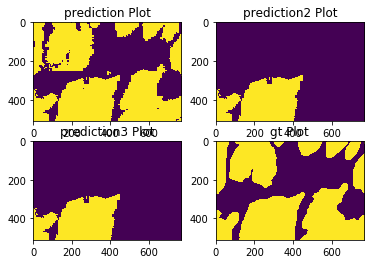

pred2: 0.5787733568617152
pred3: 0.5787733568617152
Epoch: 105, Current Dice: 0.8770, Best Dice: 0.8805

01:38:50
01:42:51
01:46:45
01:49:48
01:52:50


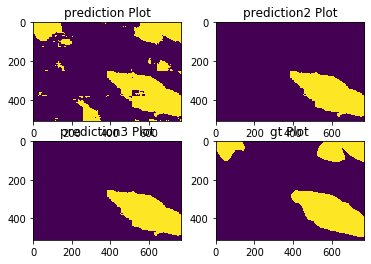

pred2: 0.5552055288594959
pred3: 0.5552055288594959
Epoch: 110, Current Dice: 0.8535, Best Dice: 0.8805

01:56:23
01:59:07
02:01:01
02:03:44
02:06:27


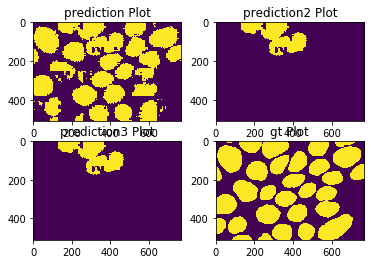

pred2: 0.5381182597443143
pred3: 0.5379779645508144
Epoch: 115, Current Dice: 0.8815, Best Dice: 0.8805

02:09:22
02:14:05
02:17:40
02:20:20


In [0]:

tf.reset_default_graph()

sess = tf.Session()

def parse_function(example_proto):
    features = {
        'label': tf.FixedLenFeature((), tf.string, default_value=""),
        'image': tf.FixedLenFeature((), tf.string, default_value="")
    }
    parsed_features = tf.parse_single_example(example_proto, features)

    lbl = tf.reshape(tf.decode_raw(parsed_features['label'], tf.int32), shape=[patch_size[0], patch_size[1]])
    img = tf.reshape(tf.decode_raw(parsed_features['image'], tf.float32), shape=[patch_size[0], patch_size[1], 3])

    return img, lbl


def read_data():
    training_data_set = tf.data.TFRecordDataset(train_file)
    training_data_set = training_data_set.shuffle(buffer_size=1000, seed=int(time.time()))
    training_data_set = training_data_set.map(parse_function)
    training_data_set.repeat()
    training_data_set = training_data_set.batch(batch_size=20)
    training_data_set = training_data_set.prefetch(tf.data.experimental.AUTOTUNE)
    test_data_set = tf.data.Dataset.from_tensor_slices((input_patches, input_labels))
    #test_data_set = tf.data.TFRecordDataset('../test_image.tfrecords')
    #test_data_set = test_data_set.map(parse_function)
    test_data_set = test_data_set.batch(batch_size=100)
    #test_data_set = test_data_set.prefetch(tf.data.experimental.AUTOTUNE)
    iterator = tf.data.Iterator.from_structure(output_types=training_data_set.output_types,
                                               output_shapes=training_data_set.output_shapes)
    training_init_op = iterator.make_initializer(training_data_set)
    test_init_op = iterator.make_initializer(test_data_set)
    next_element = iterator.get_next()
    return training_init_op, test_init_op, next_element


def train(c):
    sess.run(train_init)
    while True:
        try:
            sess.run(train_step, feed_dict={is_training: True})
        except tf.errors.OutOfRangeError:
            break
    print(time.strftime('%H:%M:%S', time.gmtime(time.time() - c)))



def evaluate(epoch):
    if not os.path.exists(os.path.join(result_images_file % epoch)):
        os.mkdir(os.path.join(result_images_file % epoch))
    stat_dict = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }
    stat_dict2 = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }
    stat_dict3 = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }

    y_label = []
    y_scores = []
    train_files = 85 + 1
    test_files = 60 + 1
    dataset_size = 0

    import random
    randvalue = random.randint(1, 60)

    for i in range(1, test_files): 

      im_file = 'testA_' + str(i) + '.bmp'
      gt_file = 'testA_' + str(i) + '_anno.bmp'

      #read and normalize
      s = imageio.imread(os.path.join(im_dir, im_file))
      #s[:,:,0] = rank.equalize(s[:,:,0], selem = disk(patch_size[0]))
      mean = np.mean(s)
      std = np.std(s)
      s = (s - mean) / std
      gt = imageio.imread(os.path.join(im_dir, gt_file)).astype(np.bool).astype(np.uint8)

      # width and height offset to cut out to be able to divide image into correct patch sizes
      h_o = (len(s) % patch_size[0]) / 2
      w_o = (len(s[0]) % patch_size[1]) / 2
      x_s, y_s = floor(w_o), floor(h_o)
      h_new, w_new = int(len(s)/patch_size[0])*patch_size[0], int(len(s[0])/patch_size[1])*patch_size[1]
      s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
      gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]


      image_patches = view_as_blocks(s, (patch_size[0], patch_size[1], 3)).reshape(-1, middle_point[0], middle_point[1], 3)
      gt_patches = view_as_blocks(gt, (patch_size[0], patch_size[1])).reshape(-1, middle_point[0], middle_point[1])

      sess.run(test_init, feed_dict={input_patches: image_patches, input_labels: gt_patches})

      fcn_output = []
      while True:
          try:
              fcn_output.append(sess.run(output, feed_dict={is_training: False}))
          except tf.errors.OutOfRangeError:
              break
        #___________________________________________________________________________________________
        #___Holding into account stepsize and overlappings (cropping is done, no average taken)____#

      fcn_output2 = []
      fcn_output = np.concatenate(fcn_output, axis=0) 
      gt2 = []

      fcn_output2 = np.array(fcn_output)

      num_col = gt.shape[1] // middle_point[1]
      num_row = gt.shape[0] // middle_point[0]

      scores = fcn_output2[:, :, :, 1]
      scores = scores.reshape(-1, middle_point[0], middle_point[1])
      predictions = np.argmax(fcn_output2, axis=-1)
      
      scores = scores.reshape(num_row, num_col, middle_point[0], middle_point[1])
      predictions = predictions.reshape(num_row, num_col, middle_point[0], middle_point[1])
      predictions = predictions.swapaxes(2, 1)
      prediction = predictions.reshape(num_row*middle_point[0], num_col*middle_point[1])
      scores = scores.swapaxes(2, 1)
      score = scores.reshape(num_row*middle_point[0], num_col*middle_point[1])
      #___________________________________________________________________________________________

      generated_map = np.hstack((prediction.astype(np.uint8), gt)) * 255
      imageio.imwrite(os.path.join(result_images_folder, str(epoch), str(str(i) + '.bmp')),
                      generated_map)


      from scipy import ndimage
      from skimage.measure import label
      prediction2 = ndimage.morphology.binary_fill_holes(prediction).astype(int)
      labelss = label(prediction2)
      if labelss.max() != 0:
          prediction2 = labelss == np.argmax(np.bincount(labelss.flat)[1:]) + 1
      stat_dict2['tp'] += np.sum(np.logical_and(prediction2 == 1, gt == 1))
      stat_dict2['tn'] += np.sum(np.logical_and(prediction2 == 0, gt == 0))
      stat_dict2['fp'] += np.sum(np.logical_and(prediction2 == 1, gt == 0))
      stat_dict2['fn'] += np.sum(np.logical_and(prediction2 == 0, gt == 1))

      labelss = label(prediction)
      prediction3 = prediction
      if labelss.max() != 0:
          prediction3 = labelss == np.argmax(np.bincount(labelss.flat)[1:]) + 1
      prediction3 = ndimage.morphology.binary_fill_holes(prediction3).astype(int)
      stat_dict3['tp'] += np.sum(np.logical_and(prediction3 == 1, gt == 1))
      stat_dict3['tn'] += np.sum(np.logical_and(prediction3 == 0, gt == 0))
      stat_dict3['fp'] += np.sum(np.logical_and(prediction3 == 1, gt == 0))
      stat_dict3['fn'] += np.sum(np.logical_and(prediction3 == 0, gt == 1))

      stat_dict['tp'] += np.sum(np.logical_and(prediction == 1, gt == 1))
      stat_dict['tn'] += np.sum(np.logical_and(prediction == 0, gt == 0))
      stat_dict['fp'] += np.sum(np.logical_and(prediction == 1, gt == 0))
      stat_dict['fn'] += np.sum(np.logical_and(prediction == 0, gt == 1))

      if randvalue == i:
        a1 = plt.subplot(2, 2, 1)
        plt.imshow(prediction)
        a2 = plt.subplot(2, 2, 2)
        plt.imshow(prediction2)
        a3 = plt.subplot(2, 2, 3)
        plt.imshow(prediction3)
        a4 = plt.subplot(2, 2, 4)
        plt.imshow(gt)
        a1.title.set_text('prediction Plot')
        a2.title.set_text('prediction2 Plot')
        a3.title.set_text('prediction3 Plot')
        a4.title.set_text('gt Plot')
        plt.show()
        #input()

    accuracy_ = (stat_dict['tp'] + stat_dict['tn']) / (
                stat_dict['fp'] + stat_dict['fn'] + stat_dict['tp'] + stat_dict['tn'])
    sensitivity_ = stat_dict['tp'] / (stat_dict['tp'] + stat_dict['fn'])
    specificity_ = stat_dict['tn'] / (stat_dict['fp'] + stat_dict['tn'])
    dice_ = float(2 * stat_dict['tp']) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']))


    global stat_file
    file = open(stat_file, 'a')
    # Auc_Roc: %0.4lf {roc_auc_}
    file.write('tp: %d, tn: %d, fp: %d, fn: %d\naccuracy: %lf\n\nsensitivity: %lf\nspecificity: %lf\ndice: %lf\n' %
               (stat_dict['tp'], stat_dict['tn'], stat_dict['fp'], stat_dict['fn'], accuracy_, sensitivity_,
                specificity_, dice_))
    file.close()
    
    print("pred2: " + str(float(2 * stat_dict2['tp']) / ((2 * stat_dict2['tp']) + (stat_dict2['fp'] + stat_dict2['fn']))))
    print("pred3: " + str(float(2 * stat_dict3['tp']) / ((2 * stat_dict3['tp']) + (stat_dict3['fp'] + stat_dict3['fn']))))

    return dice_


#image_files = os.listdir(s_dir)

input_patches = tf.placeholder(dtype=tf.float32, shape=[None, patch_size[0], patch_size[1], 3], name='patches')
input_labels = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='labels')
is_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_training')

# last_pred = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='last_pred')

variables = dict()

variables['wconv1'] = tf.get_variable(name='wconv1', shape=[3, 3, 3, 64])
variables['bconv1'] = tf.get_variable(name='bconv1', shape=[64])
variables['wconv2'] = tf.get_variable(name='wconv2', shape=[3, 3, 64, 64])
variables['bconv2'] = tf.get_variable(name='bconv2', shape=[64])

variables['wconv3'] = tf.get_variable(name='wconv3', shape=[3, 3, 64, 128])
variables['bconv3'] = tf.get_variable(name='bconv3', shape=[128])
variables['wconv4'] = tf.get_variable(name='wconv4', shape=[3, 3, 128, 128])
variables['bconv4'] = tf.get_variable(name='bconv4', shape=[128])

variables['wconv5'] = tf.get_variable(name='wconv5', shape=[3, 3, 128, 256])
variables['bconv5'] = tf.get_variable(name='bconv5', shape=[256])
variables['wconv6'] = tf.get_variable(name='wconv6', shape=[3, 3, 256, 256])
variables['bconv6'] = tf.get_variable(name='bconv6', shape=[256])

variables['wconv7'] = tf.get_variable(name='wconv7', shape=[3, 3, 256, 512])
variables['bconv7'] = tf.get_variable(name='bconv7', shape=[512])
variables['wconv8'] = tf.get_variable(name='wconv8', shape=[3, 3, 512, 512])
variables['bconv8'] = tf.get_variable(name='bconv8', shape=[512])

variables['wconv9'] = tf.get_variable(name='wconv9', shape=[3, 3, 512, 512])
variables['bconv9'] = tf.get_variable(name='bconv9', shape=[512])
variables['wconv10'] = tf.get_variable(name='wconv10', shape=[3, 3, 512, 512])
variables['bconv10'] = tf.get_variable(name='bconv10', shape=[512])

variables['wfcn1'] = tf.get_variable(name='wfcn1', shape=[3, 3, 512, 4096])
variables['bfcn1'] = tf.get_variable(name='bfcn1', shape=[4096])

variables['wfcn2'] = tf.get_variable(name='wfcn2', shape=[1, 1, 4096, 2])
variables['bfcn2'] = tf.get_variable(name='bfcn2', shape=[2])

variables['wfcn3'] = tf.get_variable(name='wfcn3', shape=[1, 1, 512, 2])
variables['bfcn3'] = tf.get_variable(name='bfcn3', shape=[2])

variables['wfcn4'] = tf.get_variable(name='wfcn4', shape=[1, 1, 256, 2])
variables['bfcn4'] = tf.get_variable(name='bfcn4', shape=[2])

variables['wdeconv3'] = tf.get_variable(name='wdeconv3', shape=[4, 4, 2, 2])

variables['wdeconv2'] = tf.get_variable(name='wdeconv2', shape=[2, 2, 2, 2])

variables['wdeconv1'] = tf.get_variable(name='wdeconv1', shape=[8, 8, 2, 2])

#variables['wconv_classifier'] = tf.get_variable(name='wconv_classifier', shape=[1, 1, 64, 2])
#variables['bconv_classifier'] = tf.get_variable(name='bconv_classifier', shape=[2])

train_init, test_init, next_element = read_data()
image, labele = next_element


print(image.shape)

#ENCODER
f1 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(image, variables['wconv1'], [1, 1, 1, 1], padding='SAME', ), variables['bconv1']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv2'], [1, 1, 1, 1], padding='SAME'), variables['bconv2']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.max_pool(f1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f1.shape)

f2 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv3'], [1, 1, 1, 1], padding='SAME', ), variables['bconv3']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv4'], [1, 1, 1, 1], padding='SAME'), variables['bconv4']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.max_pool(f2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f2.shape)

pool3 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv5'], [1, 1, 1, 1], padding='SAME', ), variables['bconv5']))
pool3 = tf.layers.batch_normalization(pool3, trainable=True, training=is_training)
pool3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv6'], [1, 1, 1, 1], padding='SAME'), variables['bconv6']))
pool3 = tf.nn.max_pool(pool3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool3.shape)


pool4 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv7'], [1, 1, 1, 1], padding='SAME', ), variables['bconv7']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv8'], [1, 1, 1, 1], padding='SAME'), variables['bconv8']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.max_pool(pool4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool4.shape)

pool5 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv9'], [1, 1, 1, 1], padding='SAME', ), variables['bconv9']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wconv10'], [1, 1, 1, 1], padding='SAME'), variables['bconv10']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.max_pool(pool5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool5.shape)

conv7 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wfcn1'], [1, 1, 1, 1], padding='SAME', ), variables['bfcn1']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)
conv7 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv7, variables['wfcn2'], [1, 1, 1, 1], padding='SAME'), variables['bfcn2']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)

print(conv7.shape)

#DECODER
input_shape = tf.shape(conv7)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 2])
convt1 = tf.nn.conv2d_transpose(conv7, variables['wdeconv3'], output_shape, strides=[1, 4, 4, 1], padding='SAME')

print(convt1.shape)

input_shape = tf.shape(pool4)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 2])
convt2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wfcn3'], [1, 1, 1, 1], padding='SAME'), variables['bfcn3']))
convt2 = tf.nn.conv2d_transpose(convt2, variables['wdeconv2'], output_shape, strides=[1, 2, 2, 1], padding='SAME')

print(convt2.shape)

convt3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wfcn4'], [1, 1, 1, 1], padding='SAME'), variables['bfcn4']))

print(convt3.shape)

h = tf.math.add_n([convt1, convt2, convt3])

input_shape = tf.shape(h)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, patch_size[0], patch_size[1], 2])
h = tf.nn.conv2d_transpose(h, variables['wdeconv1'], output_shape, strides=[1, 8, 8, 1], padding='SAME')

print(h.shape)

output = tf.nn.softmax(h)


#LOSS____________________________________________________________

#def dice_loss(onehots_true, probabilities):
#  numerator = tf.reduce_sum(onehots_true * probabilities, axis=0)
#  denominator = tf.reduce_sum(onehots_true + probabilities, axis=0)
#  loss = 1 - (2 * numerator + 1) / (denominator + 1)
#  return loss

#loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=last_pred))
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labele, logits=h))

#dice_out = tf.math.subtract(output[:,:,:,1], output[:,:,:,0]) / 2 + 0.5
#labele = tf.cast(labele, tf.float32)
#h = tf.cast(h, tf.float32)
#output = tf.cast(tf.argmax(output, axis=-1), tf.int32)
#loss = dice_loss(labele, dice_out)

#______________________________________________________________

batchnorm1 = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
train_step = tf.train.AdamOptimizer(lr).minimize(loss)



train_step = tf.group([train_step, batchnorm1])
sess.run(tf.global_variables_initializer())

# Checkpoint restoration and transfer learning
saver = tf.train.Saver()

starting_epoch = 1
val_acc = 0
last_improvement = 1
best_dice = 0.0
require_improvement = 1000
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=load_dir)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")

sess.run(tf.global_variables_initializer())

# append to the accuracy file
temp = True
if temp:
    if os.stat(stat_file).st_size != 0:
        with open(stat_file, 'r') as acc_file:
            lineList = acc_file.readlines()
            float_list = []
            int_list = []
            ind = -1
            while not float_list:
                float_list = re.findall(r'\d+\.\d+', lineList[ind])
                int_list = re.findall(r'\d+', lineList[ind])
                ind -= 1
            starting_epoch = int(int_list[0]) + 1
            best_dice = float(float_list[1])
            val_acc = float(float_list[0])

# training loop
print("Starting Epoch   " + str(starting_epoch))
print("Best Dice    " + str(best_dice))
print("Current Dice " + str(val_acc))

epochs = 1000

start_time = time.time()

for epoch in range(starting_epoch, epochs):
    train(start_time)
    if not epoch % 5:
        temp_dice = evaluate(epoch)
        print('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))
        saver.save(sess=sess, save_path=save_path)

        if temp_dice > best_dice:
            saver.save(sess=sess, save_path=save_path_test)
            best_dice = temp_dice
            last_improvement = epoch

        with open(stat_file, 'a') as file:
            file.write('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))

        if epoch - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization process...")
            break

